In [1]:
# # For Google Colab
# %pip install sodapy
# %pip install python-dotenv

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import multiprocess as mp
from dotenv import load_dotenv
load_dotenv()

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

from sodapy import Socrata

from tqdm.notebook import tqdm
tqdm.pandas()

# Predicting SLA Violations of NYC311 Requests

This analysis leverages data from NYC Open Data sources:
1. **[311 Service Requests from 2010 to Present](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9):** provides 311 reporting as far back as 2010, and is updated on an automated daily basis. Each record in this dataset corresponds to a 311 service request.
2. **[311 Service Level Agreements](https://data.cityofnewyork.us/City-Government/311-Service-Level-Agreements/cs9t-e3x8):** Provides the time commitments that City Agencies have made to respond to 311 Service Requests that are assigned to them.

## Data Ingestion

### Service Level Agreements (SLAs)

A 311 Service Request is a customer request for a City Agency’s attention and response to a particular condition or situation. Service Requests are highly structured according to the information the receiving Agency needs to evaluate and respond. The Service Level Agreement (SLA) is a period of time defined by the receiving Agency  in order to provide the customer with the expected time until an update or final resolution of the request.  The SLA is defined in the customer service system used by 311 and the Agencies. Each record represents a type of Service Request and the time for response. This dataset can be used to learn about Agency areas of responsibility and response. The SLA information provided is the time the agency projects for their first response on this type of problem. Once the Service Request is received, the SLA may change as the Agency takes action an the issue, and/or this initial SLA may represent time to the Agency's first action, versus the final resolution to an issue.

In [3]:
sla = pd.read_csv("data/311_Service_Level_Agreements_20231102.csv")
# Convert text SLA durations to float (hours)
sla['sla'] = pd.to_timedelta(sla[sla.SLA.str.contains("day|hour")].SLA).dt.total_seconds() / 3600
sla = sla.sort_values(by=['Agency', 'Problem', 'Problem_Details', 'Additional Details', 'sla'],
                      ascending=[True, True, True, True, False])

# We only have 3 levels of granularity in the 311 reporting data, so we need to consolidate SLAs to some extent:
sla = sla.drop_duplicates(subset=['Agency', 'Problem', 'Problem_Details']).reset_index(drop=True)

In [4]:
sla.groupby('Agency').sla.describe()

,count,mean,std,min,25%,50%,75%,max
Agency,,,,,,,,
Administration for Children's Services,1.0,168.000000,NaN,168.0,168.00,168.0,168.00,168.0
Department for the Aging,23.0,286.956522,97.750833,72.0,336.00,336.0,336.00,336.0
Department of Buildings,115.0,813.078261,696.030111,48.0,48.00,960.0,960.00,2160.0
Department of Consumer Affairs,68.0,97.058824,8.731283,96.0,96.00,96.0,96.00,168.0
Department of Education,16.0,150.000000,38.698837,72.0,168.00,168.0,168.00,168.0
Department of Environmental Protection,88.0,107.079545,95.699628,1.0,24.00,72.0,240.00,336.0
Department of Finance,88.0,245.454545,127.657850,120.0,120.00,240.0,336.00,504.0
Department of Health and Mental Hygiene,168.0,717.857143,227.105037,72.0,720.00,720.0,888.00,1080.0
Department of Homeless Services,2.0,2.500000,2.121320,1.0,1.75,2.5,3.25,4.0


### Service Requests

In [5]:
# APP_TOKEN = os.getenv("APP_TOKEN")
APP_TOKEN="5Z1Lf9axwk4tNJMF1Q4Uz16i4"

client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

# Total number of records in this dataset
num_records = int(client.get("erm2-nwe9", query="SELECT COUNT(*)")[0]['COUNT'])
num_records

34968354

In [6]:
# %%time
# query = f"""
#     SELECT
#         unique_key, created_date, due_date, closed_date, resolution_action_updated_date, status, resolution_description,
#         agency, agency_name, community_board, open_data_channel_type, complaint_type, descriptor,
#         city, borough, incident_zip, bbl, location_type, street_name, landmark, incident_address, facility_type,
#         park_facility_name, vehicle_type, bridge_highway_name, bridge_highway_segment,
#         latitude, longitude
#     WHERE DATE_EXTRACT_Y(created_date) = "2023"
#     ORDER BY created_date
#     LIMIT {num_records}
# """
# reports = pd.DataFrame.from_records(client.get("erm2-nwe9", query=query))

In [7]:
# reports = reports.astype({'unique_key':'int32', 'latitude':float, 'longitude':float})

# for col in reports.columns[reports.columns.str.contains('date')]:
#     reports[col] = pd.to_datetime(reports[col])

In [8]:
# for col in tqdm(['status', 'agency', 'agency_name', 'community_board', 'open_data_channel_type', #'complaint_type',
#                  'city', 'borough', 'incident_zip', 'location_type']):
#     reports[col] = pd.Categorical(reports[col])

In [9]:
# # TTR = time to resolve
# # TD = timedelta = time to resolve when closed date exists, time from open to now otherwise (in hours)
# reports['td'] = (reports.closed_date.fillna(pd.Timestamp.now()) - reports.created_date).dt.total_seconds() / 3600

In [10]:
# # Save Year-To-Date data for easier access down the road
# reports.to_parquet("data/311_reports_2023.parquet", index=False)
reports = pd.read_parquet("data/311_reports_2023.parquet")
reports.shape

(2698097, 29)

## Data Engineering

### Merging
Let us figure out what are the "foreign keys" that allow us to join these datasets together

{'Department of Finance', 'Department of Information Technology and Telecommunications', 'Department of Records and Information Services', 'Mayor’s Office of Special Enforcement', 'Human Resources Administration', 'Department for the Aging', "Administration for Children's Services"}
{'Department of Consumer and Worker Protection', 'Consumer Complaints Division', 'Office of Technology and Innovation'}


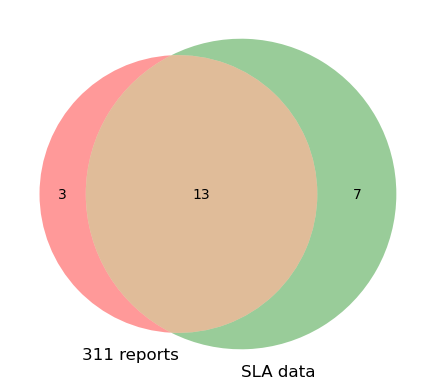

In [11]:
# Overlap in agency names
venn2([set(reports.agency_name), set(sla.Agency)], set_labels=['311 reports', 'SLA data'])
print(set(sla.Agency) - set(reports.agency_name))
print(set(reports.agency_name) - set(sla.Agency))

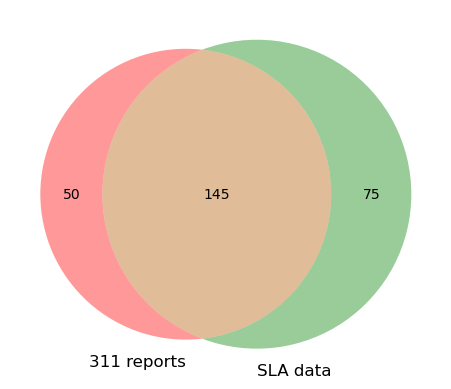

In [12]:
venn2([set(reports[reports.agency_name.isin(sla.Agency)].complaint_type),
       set(sla[sla.Agency.isin(reports.agency_name)].Problem)], 
      set_labels=['311 reports', 'SLA data'])

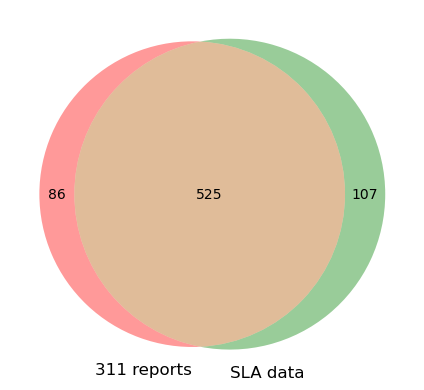

In [13]:
venn2([set(reports[(reports.agency_name.isin(sla.Agency)) & (reports.complaint_type.isin(sla.Problem))].descriptor),
       set(sla[(sla.Agency.isin(reports.agency_name)) & (sla.Problem.isin(reports.complaint_type))].Problem_Details)],
       set_labels=['311 reports', 'SLA data'])

In [14]:
sla = sla.dropna(subset=['Agency', 'Problem', 'Problem_Details']).set_index(['Agency', 'Problem', 'Problem_Details']).sla.dropna()

reports = reports.merge(sla, how='inner', left_on=['agency_name', 'complaint_type', 'descriptor'], right_index=True)
reports.shape

(1628107, 30)

In [15]:
# Thoughts: we should probably filter to data cases that have been completed already
reports = reports[(reports.status=="Closed") & (reports.closed_date.notna()) & (reports.td > 0)]
reports.shape

(1496059, 30)

### Create Target Variable

In [16]:
reports['breached'] = reports.td > reports.sla
reports.groupby('agency_name').breached.agg(['count', 'sum', 'mean'])

,count,sum,mean
agency_name,,,
Department of Consumer Affairs,7631,80,0.010484
Department of Education,949,381,0.401475
Department of Health and Mental Hygiene,22810,714,0.031302
Department of Homeless Services,22,9,0.409091
Department of Parks and Recreation,61940,21489,0.346933
Department of Sanitation,169465,62504,0.368831
Department of Transportation,70371,10402,0.147817
Economic Development Corporation,32911,32908,0.999909
New York City Police Department,1108494,37894,0.034185


Moving forward let's remove `Economic Development Corporation` service requests, as they only seem to field one type of complaint (`Noise - Helicopter`) with response "this issue is not within its jurisdiction".

In [17]:
reports = reports[~reports.agency_name.isin(['Economic Development Corporation'])]
reports.breached.value_counts(1)

breached
False    0.898941
True     0.101059
Name: proportion, dtype: float64

### Feature Engineering

#### Word Embeddings

In [18]:
# # run this from a normal command line
# !python -m spacy download en_core_web_md
import spacy
nlp = spacy.load('en_core_web_md')

In [19]:
reports['document'] = (
    reports.complaint_type \
    + ' ' + reports.descriptor \
    + ' ' + reports.location_type.astype(str) \
    + ' ' + reports.community_board.astype(str)
    # + ' ' + reports.street_name \
    + ' ' + reports.incident_address.fillna('') \
    + ' ' + reports.park_facility_name \
    + ' ' + reports.bridge_highway_name.fillna('') \
    + ' ' + reports.vehicle_type.fillna('') \
    # + ' ' + reports.resolution_description.fillna('') # not available when first created
)

In [20]:
%%time

# Get the mean vector for the entire sentence (useful for sentence classification etc.)
# Takes awhile so let's parallelize it!
with mp.Pool() as pool:
    pooled_results = pool.map(lambda x: nlp(x).vector, reports.document)
len(pooled_results)

CPU times: user 8.51 s, sys: 7.75 s, total: 16.3 s
Wall time: 18min 26s


1463148

In [21]:
embeddings = np.stack(pooled_results)
embeddings = pd.DataFrame(embeddings, columns = [f'e{i}' for i in range(300)])
embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463148 entries, 0 to 1463147
Columns: 300 entries, e0 to e299
dtypes: float32(300)
memory usage: 1.6 GB


#### Combining

First, let's drop all the features that are either irrelevant, 1:1 mapped, related to other fields, or wouldn't be known at inference time:

In [22]:
# reports = reports.drop(columns=['unique_key', 'closed_date', 'resolution_action_updated_date', 'status',
#                                 'agency', # we already have agency_name
#                                 'city', 'borough', # effectively captured in community board
#                                 'street_name', 'landmark', 'incident_address',
#                                 'park_facility_name', 'facility_type',
#                                 'bridge_highway_name', 'bridge_highway_segment', 'vehicle_type',
#                                 # borough-block-lot so granular we might as well figure out how to work with lat/long
#                                 'incident_zip', 'bbl',
#                                 'due_date'])

Now, let's create some features so we can work with time-based features:

In [23]:
reports[f"created_month"] = reports.created_date.dt.month
reports[f"created_hour"] = reports.created_date.dt.hour
reports[f"created_dayofweek"] = reports.created_date.dt.dayofweek
# reports = reports.drop(columns=['created_date'])

In [24]:
reports = reports[['breached', 'agency_name', 'open_data_channel_type', 'latitude', 'longitude', 'created_month', 'created_hour', 'created_dayofweek']].reset_index(drop=True)

In [25]:
combined_reports = pd.concat([reports, embeddings], axis=1)
combined_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463148 entries, 0 to 1463147
Columns: 308 entries, breached to e299
dtypes: bool(1), category(1), float32(300), float64(2), int32(3), object(1)
memory usage: 1.7+ GB


## Write Outputs

In [26]:
# Save Year-To-Date data for easier access down the road
combined_reports.to_parquet("data/311_reports_2023_embeddings.parquet", index=False)